# Simulations

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import anndata
import numpy as np
import pandas as pd
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import os,sys,inspect
# setting the path to source
# sys.path.insert(0,os.path.dirname(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))) + '/source') 
sys.path.append('../source') 

# new source imports 
import OrgAlign as orgalign
import Main
import MyFunctions 
import TimeSeriesPreprocessor
# import PathwayAnalyser

import warnings
warnings.filterwarnings("ignore")

## Test on pancreas dataset

In [3]:
# pip install git+https://github.com/theislab/cellrank

In [4]:
import scanpy as sc
from cellrank.datasets import pancreas_preprocessed

In [5]:
adata = pancreas_preprocessed()
adata.obs['time'] = adata.obs['dpt_pseudotime'].copy()
adata.X = adata.X.toarray()

In [6]:
# keep only differentiation 2 beta lineage
adata = adata[adata.obs['clusters'].isin(['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Beta'])].copy()

In [7]:
adata

AnnData object with n_obs × n_vars = 1845 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'dpt_pseudotime', 'time'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'diffmap_evals', 'iroot', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_diffmap', 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', '

/home/jovyan/my-conda-envs/genes2genes-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


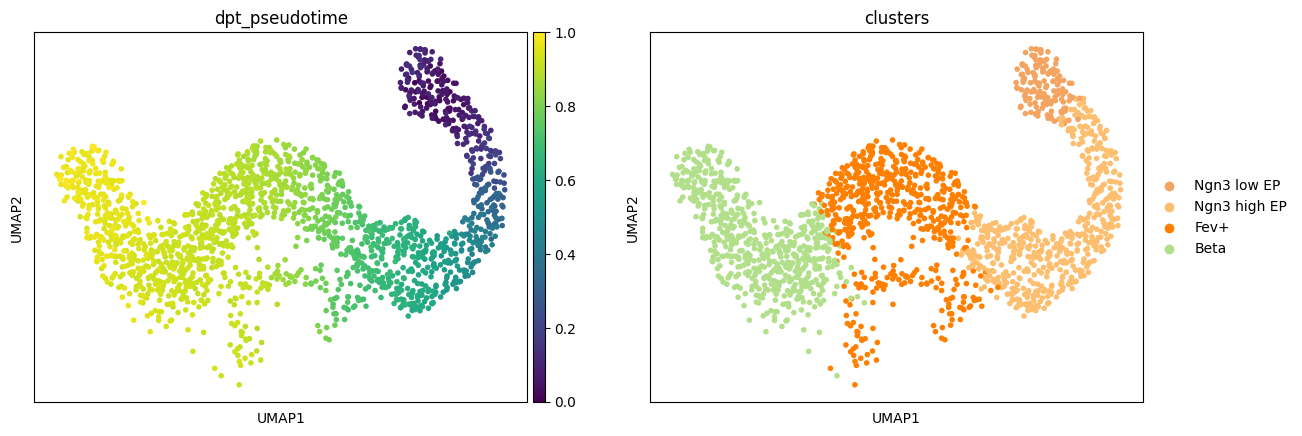

In [8]:
sc.pl.umap(adata, color=['dpt_pseudotime', 'clusters'])

### Simulation utils

In [284]:
def simulate_alignment2(adata, true_align_string, 
                       frac_query = 0.5,
                       seed=42352,
                       gene = 'Msi1',
                       n_stds = 3):
    np.random.seed(seed)
    n_bins=len(true_align_string)
    adata.obs['time_bins'] = pd.cut(adata.obs['time'], n_bins).astype('category').cat.codes
    q_cells= np.array([])

    ## Split in ref and query
    for i,b in enumerate(true_align_string):
        n_cells = sum(adata.obs['time_bins'] == i)
        q_cells_bin = np.random.choice(adata.obs_names[adata.obs['time_bins'] == i], size=int(np.round(n_cells*frac_query)), replace=False)
        q_cells = np.hstack([q_cells, q_cells_bin])

    adata_query = adata[q_cells].copy()
    adata_ref = adata[~adata.obs_names.isin(q_cells)].copy()
    
    ## Calculate shift for insertion
    X_query = adata_query.X.copy()
    X_gene = X_query[:,adata_query.var_names == gene]
    ins_shift = n_stds*X_gene.std()
    
    for i,b in enumerate(true_align_string):
        bcells = adata_query.obs_names[adata_query.obs['time_bins'] == i]
        if b == 'D': ## delete cells
            adata_query = adata_query[~adata_query.obs_names.isin(bcells)].copy()
        if b == 'I': # change values for gene expression            
            X_query = adata_query.X.copy()
            X_gene = X_query[adata_query.obs_names.isin(bcells),adata_query.var_names == gene]
            X_query[adata_query.obs_names.isin(bcells),adata_query.var_names == gene] = X_gene + ins_shift
            adata_query.X = X_query.copy()
    return(adata_ref, adata_query)

In [225]:
def make_align_string(mm_type, mm_start = 10, n_bins = 40, mm_size=10):
    mm_ixs = range(mm_start, mm_start+mm_size)
    true_align_string = ''.join([mm_type if i in mm_ixs else 'M' for i in range(n_bins)])
    return(true_align_string)

def alignment_viz(aligner, al_obj):
#     plt.subplots(1,2,figsize=(10,3))
#     plt.subplot(1,2,1)
#     al_obj.plotTimeSeries(aligner, plot_cells=True)
#     plt.subplot(1,2,2)
#     al_obj.plotTimeSeriesAlignment()
    print(al_obj.al_visual)
    
def predict_alignment(adata_ref, adata_query, gene, n_bins=40):
    gene_list = adata_ref.var_names 
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, n_bins)
    aligner.WEIGHT_BY_CELL_DENSITY = True
    al_obj = aligner.align_single_pair(gene)
#     alignment_viz(aligner, al_obj)
    return(al_obj)

def get_ref_aling_str(al_obj):
    ref_ixs = (al_obj.al_visual.split('\n')[1]).split(' Reference')[0]
    al_str = al_obj.alignment_str

    ref_aling_str = ''.join([al_str[i] for i,p in enumerate(ref_ixs) if p!=' '])

    # collapse Vs
    ref_aling_str_collapsed = ''
    for i,p in enumerate(ref_aling_str):
        if p == 'V':
            if ref_aling_str[i-1]!='V':
                ref_aling_str_collapsed += 'M'
            else:
                ref_aling_str_collapsed += ''
        else:
            ref_aling_str_collapsed += p
    return(ref_aling_str_collapsed)

## Match/mismatch accuracy

In [137]:
def run_match_accuracy(params):
    adata, gene, align_params = params
    match_dict = {'D':'mismatch', 'I':'mismatch', 'M':'match', 'V':'match', 'W':'match'}
    true_align_string = make_align_string(**align_params)
    rdata, qdata = simulate_alignment2(adata, true_align_string, gene=gene)
    al_obj = predict_alignment(rdata, qdata, gene=gene)

    true_ref_align_str = get_ref_aling_str(al_obj)

    # get mismatch accuracy
    outcome_df = pd.DataFrame([(i, match_dict[true_align_string[i]], match_dict[c]) for i,c in enumerate(get_ref_aling_str(al_obj) )],
                 columns=['position', 'true', 'predicted']
                )
    outcome_df['correct'] = outcome_df['true'] == outcome_df['predicted']
    accuracy = outcome_df['correct'].sum()/outcome_df['correct'].shape[0]
    outcome_df['accuracy'] = accuracy
    outcome_df['gene'] = gene
    for p in align_params.keys():
        outcome_df[p] = align_params[p]
    outcome_df = outcome_df[list(align_params.keys()) + ['gene', 'accuracy']].drop_duplicates()
    return(outcome_df)

# gene = 'Rgs17'
# match_outcome = pd.DataFrame()
# for st in range(0,35,5):
#     for s in [3, 5, 10, 15, 20]:
#         align_params={'mm_type':'D', 'n_bins':40, 'mm_start':st, 'mm_size':s}
#         match_outcome = pd.concat([match_outcome, run_match_accuracy(gene, align_params)])


Select genes

N tested genes:  1251


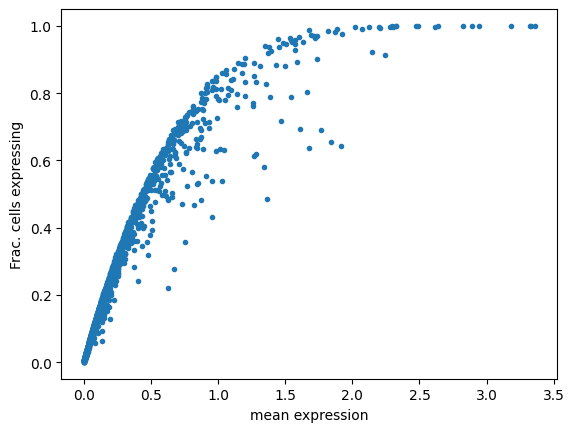

In [128]:
## Exclude genes with very low mean expression on this subset (they get low accuracy because of noise)
mean_gex = adata.X.mean(0)
X_bin = adata.X.copy()
X_bin[X_bin.nonzero()] = 1
frac_cells = X_bin.sum(0)/X_bin.shape[0]
plt.plot(mean_gex, frac_cells, '.');
plt.xlabel('mean expression');
plt.ylabel('Frac. cells expressing');

genes = adata.var_names[(mean_gex > 0.1) & (frac_cells > 0.1)]
print('N tested genes: ', len(genes))

### Simulate deletions

In [ ]:
import multiprocessing
mm_sizes = [0,1, 3, 5, 10, 15, 20]
match_outcome = pd.DataFrame()
for i,g in enumerate( genes ):
    pool = multiprocessing.Pool(7)
    outcomes_g = pool.map(
        run_match_accuracy, [(adata, g, {'mm_type':'D', 'n_bins':40, 'mm_start':0, 'mm_size':s}) for s in mm_sizes])
    outcomes_g = pd.concat(outcomes_g)
    pool.close()
    match_outcome = pd.concat([match_outcome, outcomes_g])

list index out of range Snhg6
list index out of range Uggt1
list index out of range Tmem131
list index out of range Fhl2
list index out of range Tex30
list index out of range Ankrd44
list index out of range Clk1
list index out of range Klf7
list index out of range Kif1a
list index out of range Pam
list index out of range Dbi
list index out of range Tmem163
list index out of range Mcm6
list index out of range Btg2
list index out of range Rnpep
list index out of range Nav1
list index out of range Nek7
list index out of range Swt1
list index out of rangeDhx9 
list index out of range Qsox1
list index out of rangeSoat1 
list index out of range Cacybp
list index out of range Atp1b1
list index out of range Mpzl1
list index out of range Mgst3
list index out of range Pea15a
list index out of range Wdr26
list index out of range Capn2
list index out of range Prox1
list index out of range Rcor3
list index out of range St18
list index out of range
 Pcmtd1list index out of range Cspp1
list index out

In [187]:
match_outcome.to_csv('./data/match_accuracy_pancreas.deletion.csv')

In [40]:
# match_outcome = pd.DataFrame()
# for g in genes:
#     for st in range(0,35,5):
#         for s in [1, 3, 5, 10, 15, 20]:
#             align_params={'mm_type':'D', 'n_bins':40, 'mm_start':st, 'mm_size':s}
#             match_outcome = pd.concat([match_outcome, run_match_accuracy(g, align_params)])

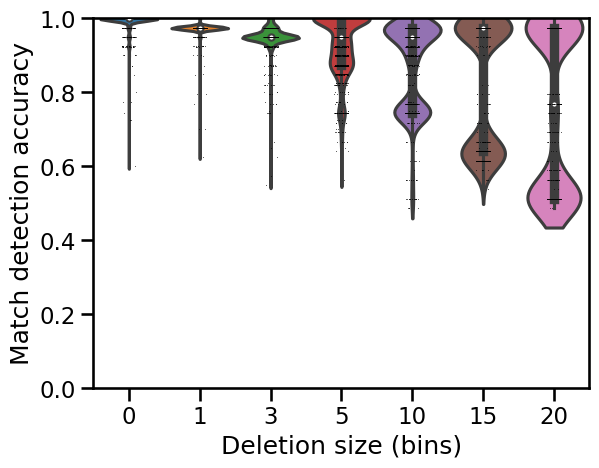

In [177]:
import seaborn as sns
sns.set_context("talk")
sns.violinplot(data=match_outcome, x='mm_size', y='accuracy', cut=True, scale='width');
sns.stripplot(data=match_outcome, x='mm_size', y='accuracy', color='black', s=0.5);
plt.ylim(0,1.0);
plt.xlabel("Deletion size (# bins)");
plt.ylabel("Match detection accuracy");

Plot accuracy by gene

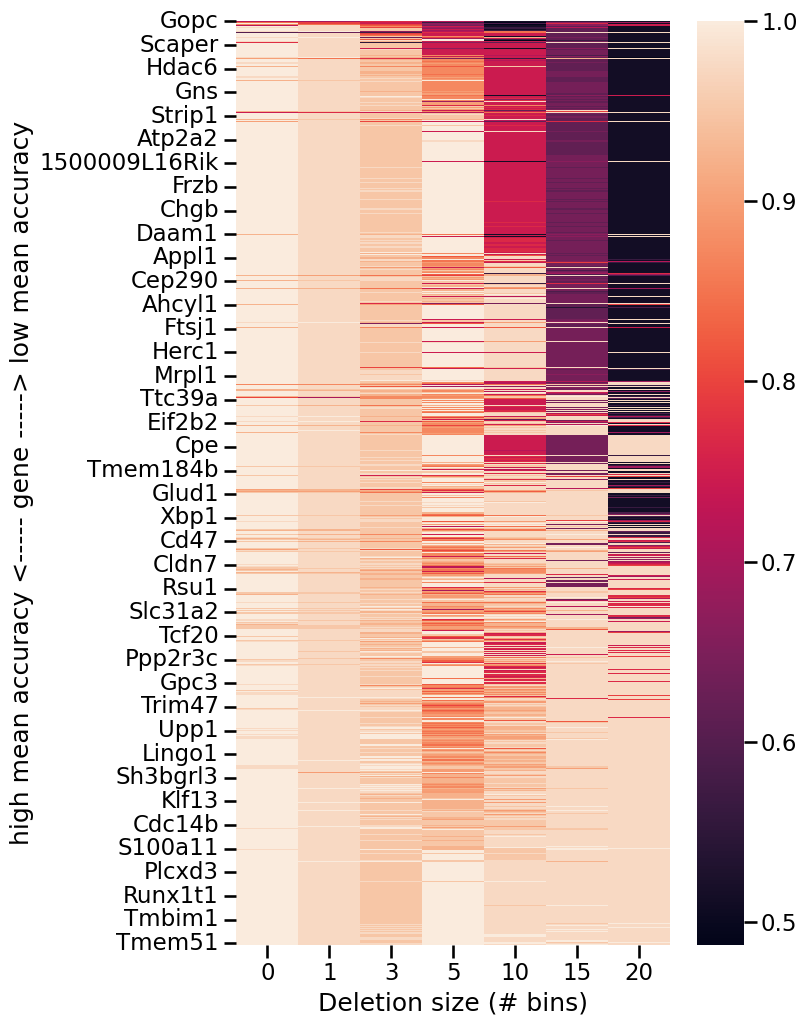

In [189]:
acc_matrix = match_outcome[['accuracy', 'gene', 'mm_size']].pivot(index='gene', columns='mm_size', values='accuracy')
acc_matrix = acc_matrix.dropna()

## order by mean accuracy
acc_matrix = acc_matrix.loc[acc_matrix.mean(1).sort_values().index]


with plt.rc_context({'figure.figsize':[7,12]}):
    sns.heatmap(acc_matrix);
    plt.xlabel("Deletion size (# bins)");
    plt.ylabel('high mean accuracy <----- gene -----> low mean accuracy')

Visualize trend of high accuracy and low accuracy genes

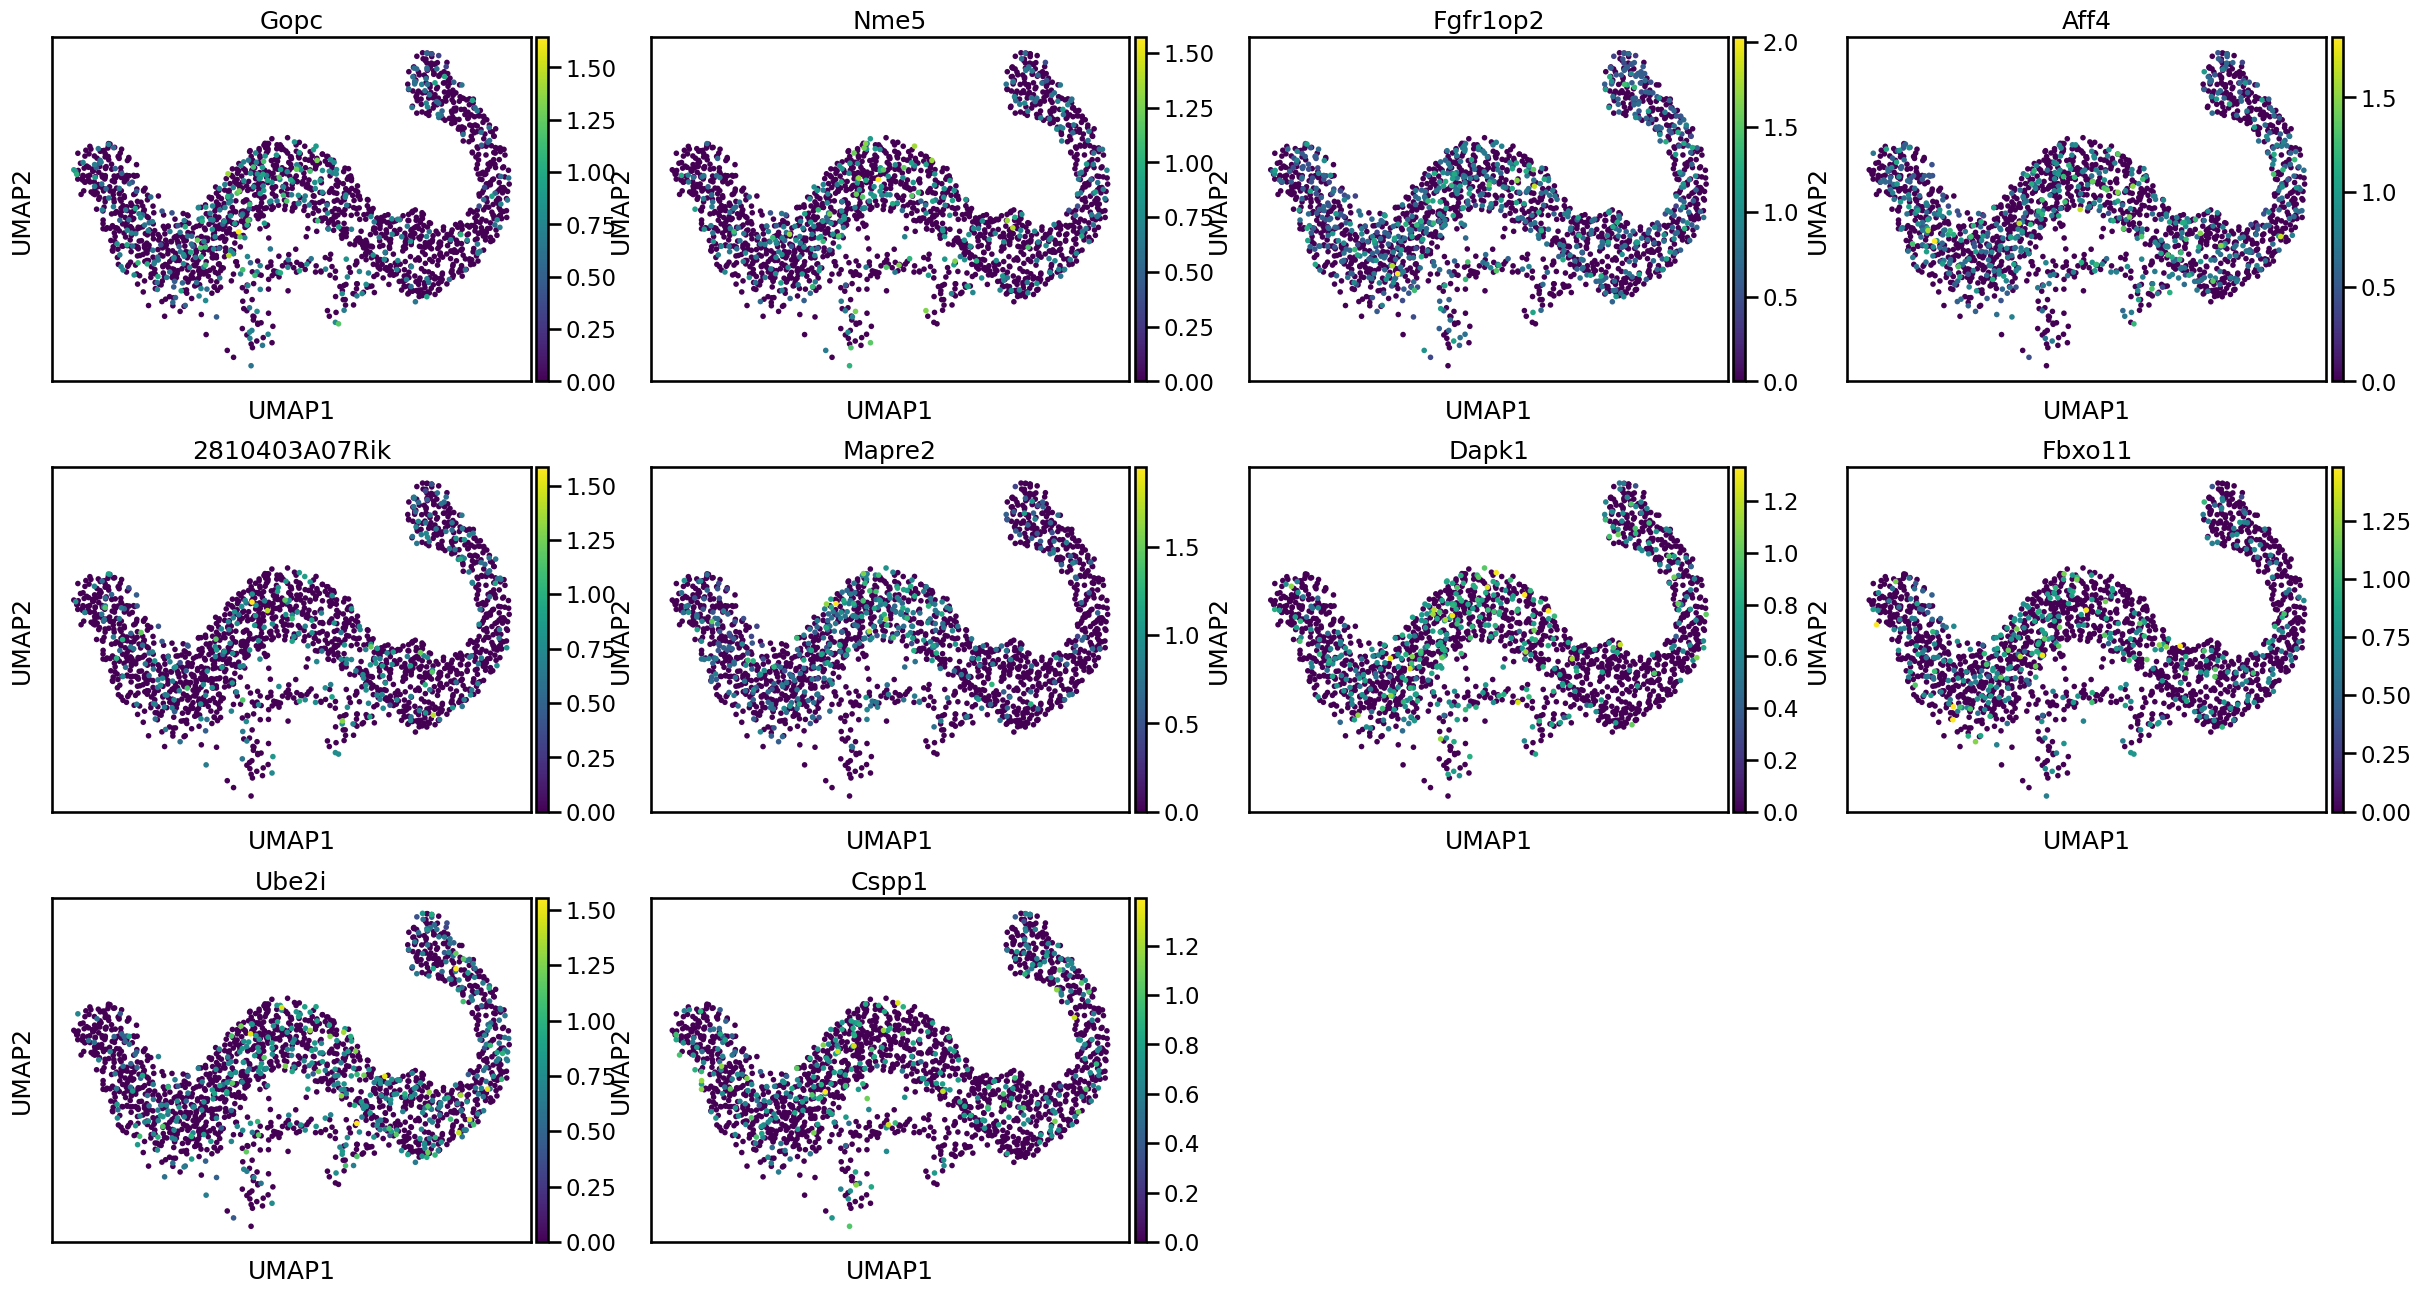

In [190]:
sc.pl.umap(adata, color=acc_matrix[0:10].index.tolist())

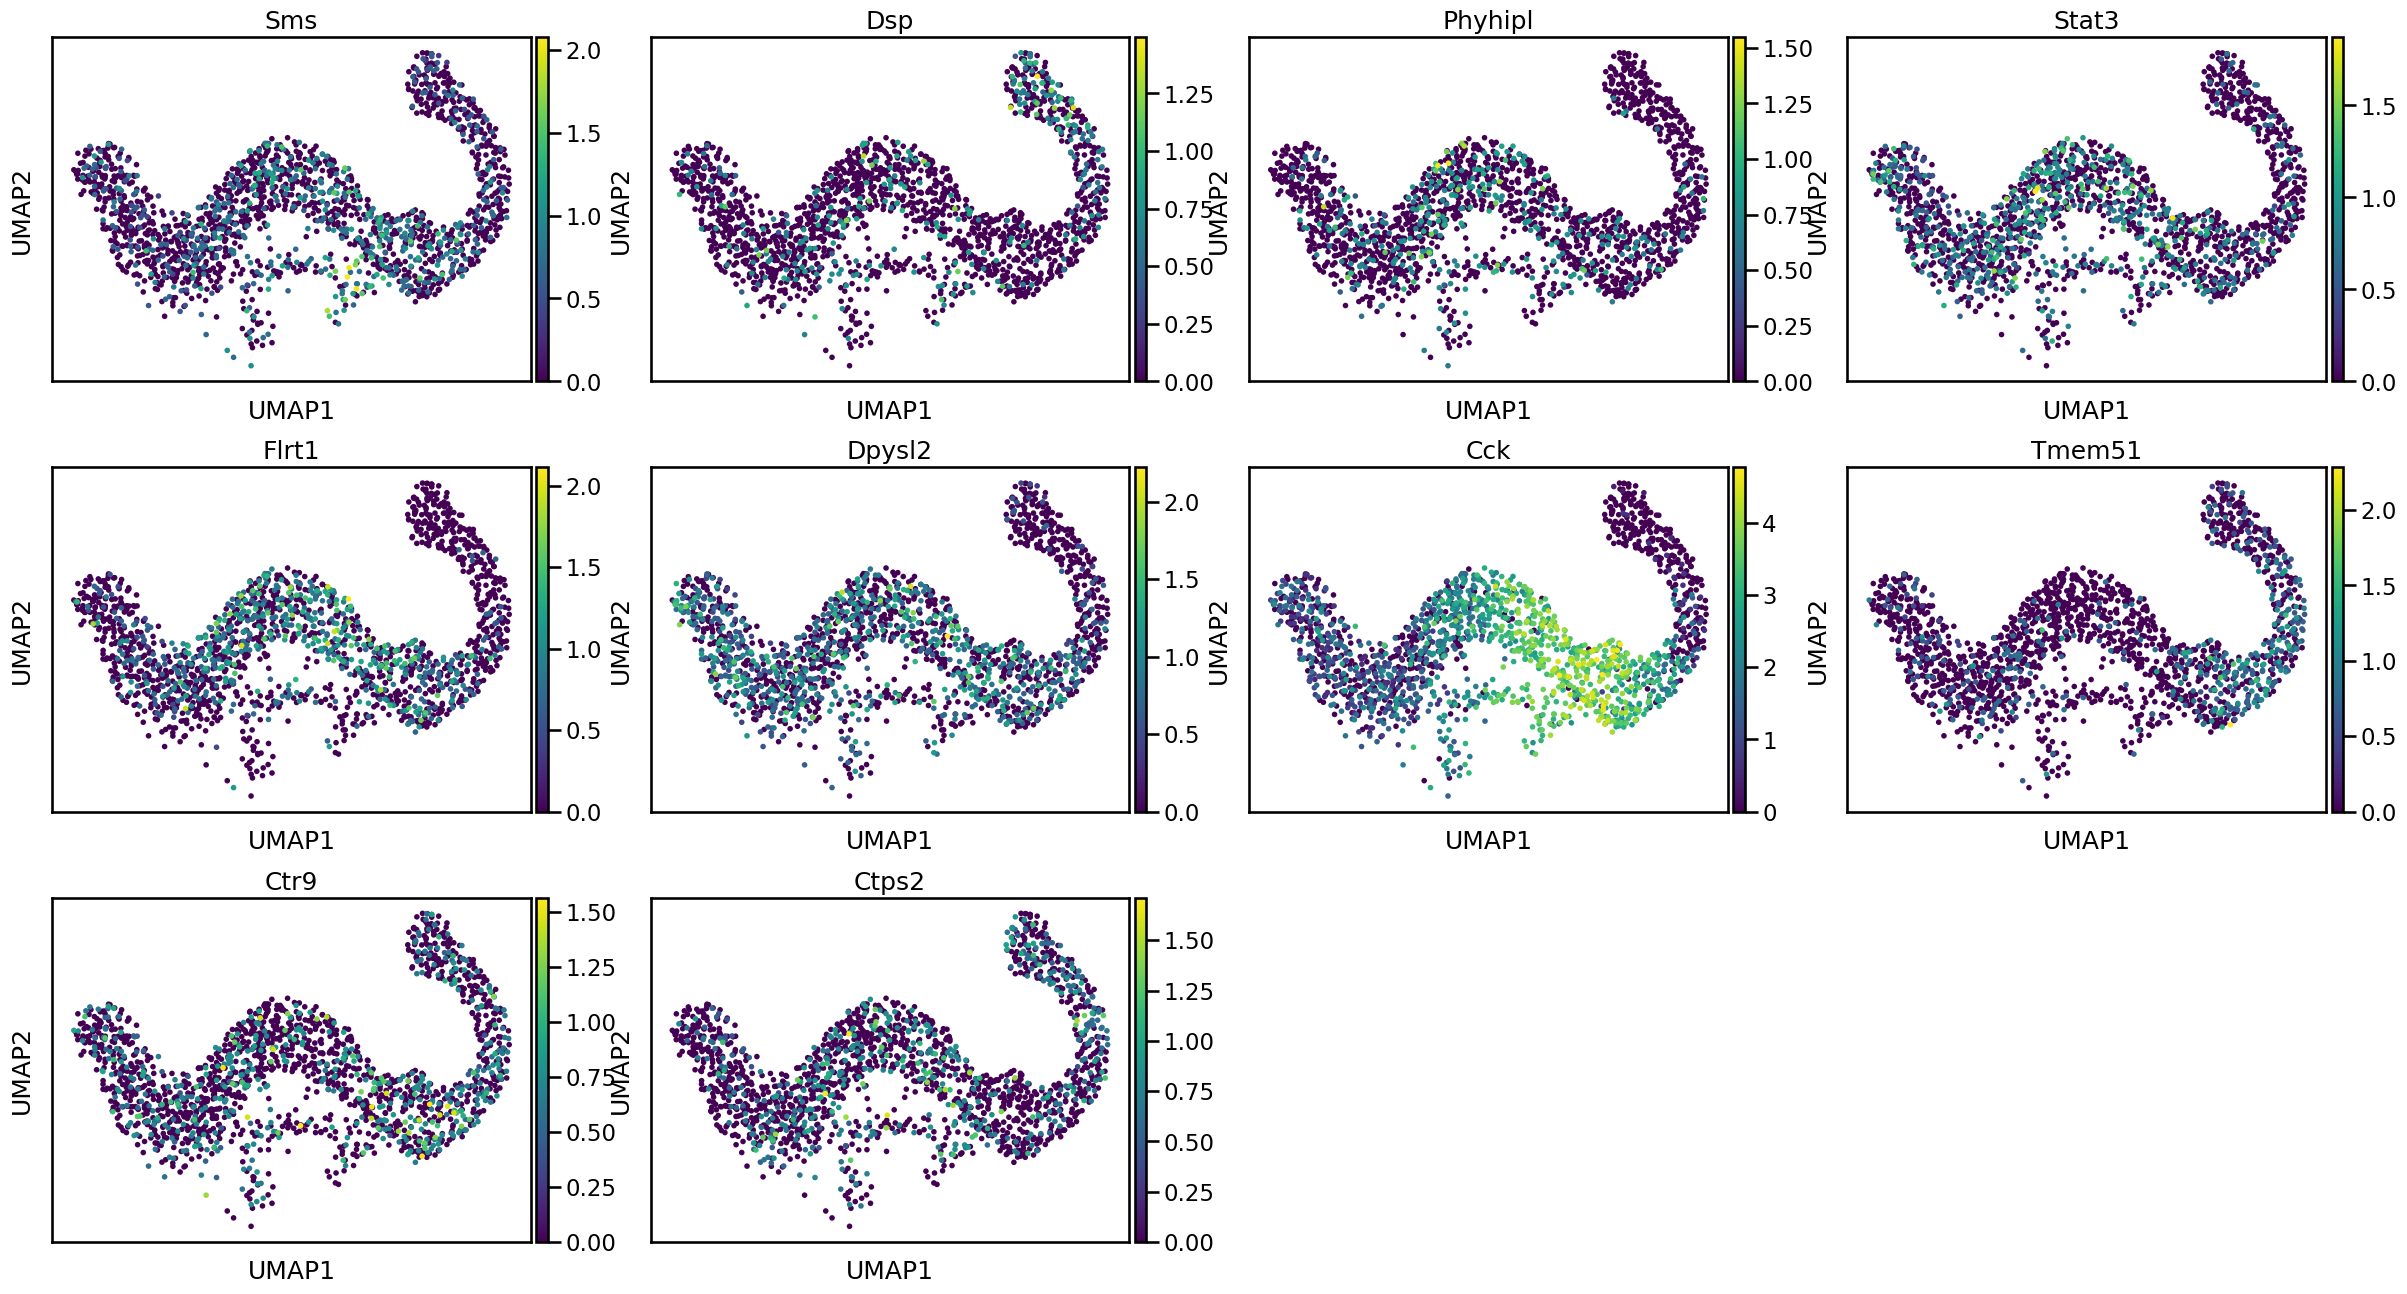

In [191]:
sc.pl.umap(adata, color=acc_matrix[-10:].index.tolist())

### Simulate insertions

In [ ]:
import multiprocessing
mm_sizes = [0,1, 3, 5, 10, 15, 20]
match_outcome = pd.DataFrame()
for i,g in enumerate( genes ):
# for i,g in enumerate( np.random.choice(genes, 10, replace=False) ):
    pool = multiprocessing.Pool(7)
    outcomes_g = pool.map(
        run_match_accuracy, [(adata, g, {'mm_type':'I', 'n_bins':40, 'mm_start':0, 'mm_size':s}) for s in mm_sizes])
    outcomes_g = pd.concat(outcomes_g)
    pool.close()
    match_outcome = pd.concat([match_outcome, outcomes_g])

list index out of range Snhg6
list index out of range Snhg6
list index out of range Snhg6
list index out of range Snhg6
list index out of range Snhg6
list index out of range Snhg6
list index out of range Snhg6
list index out of range Uggt1
list index out of range Uggt1
list index out of range Uggt1
list index out of range Uggt1
list index out of range Uggt1
list index out of range Uggt1
list index out of range Uggt1
list index out of rangeTmem131 
list index out of range Tmem131
list index out of range Tmem131
list index out of range Tmem131
list index out of range Tmem131
list index out of range Tmem131
list index out of range Tmem131
list index out of range Fhl2
list index out of range Fhl2
list index out of range Fhl2
list index out of range Fhl2
list index out of range Fhl2
list index out of range Fhl2
list index out of range Fhl2
list index out of range Tex30
list index out of range Tex30
list index out of range Tex30
list index out of range Tex30
list index out of range Tex30
lis

In [295]:
match_outcome.to_csv('./data/match_accuracy_pancreas.insertions.csv')

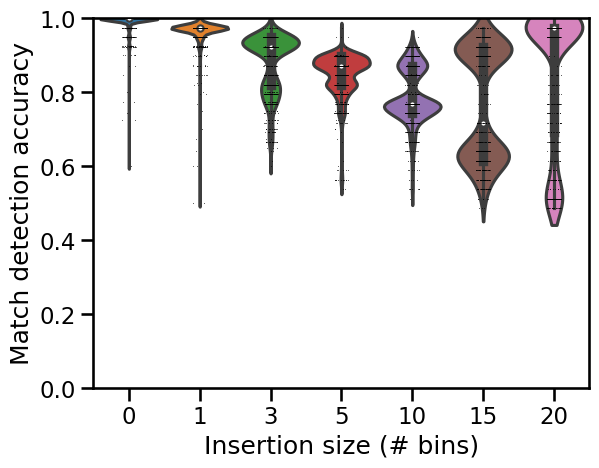

In [296]:
import seaborn as sns
sns.set_context("talk")
sns.violinplot(data=match_outcome, x='mm_size', y='accuracy', cut=True, scale='width');
sns.stripplot(data=match_outcome, x='mm_size', y='accuracy', color='black', s=0.5);
plt.ylim(0,1.0);
plt.xlabel("Insertion size (# bins)");
plt.ylabel("Match detection accuracy");

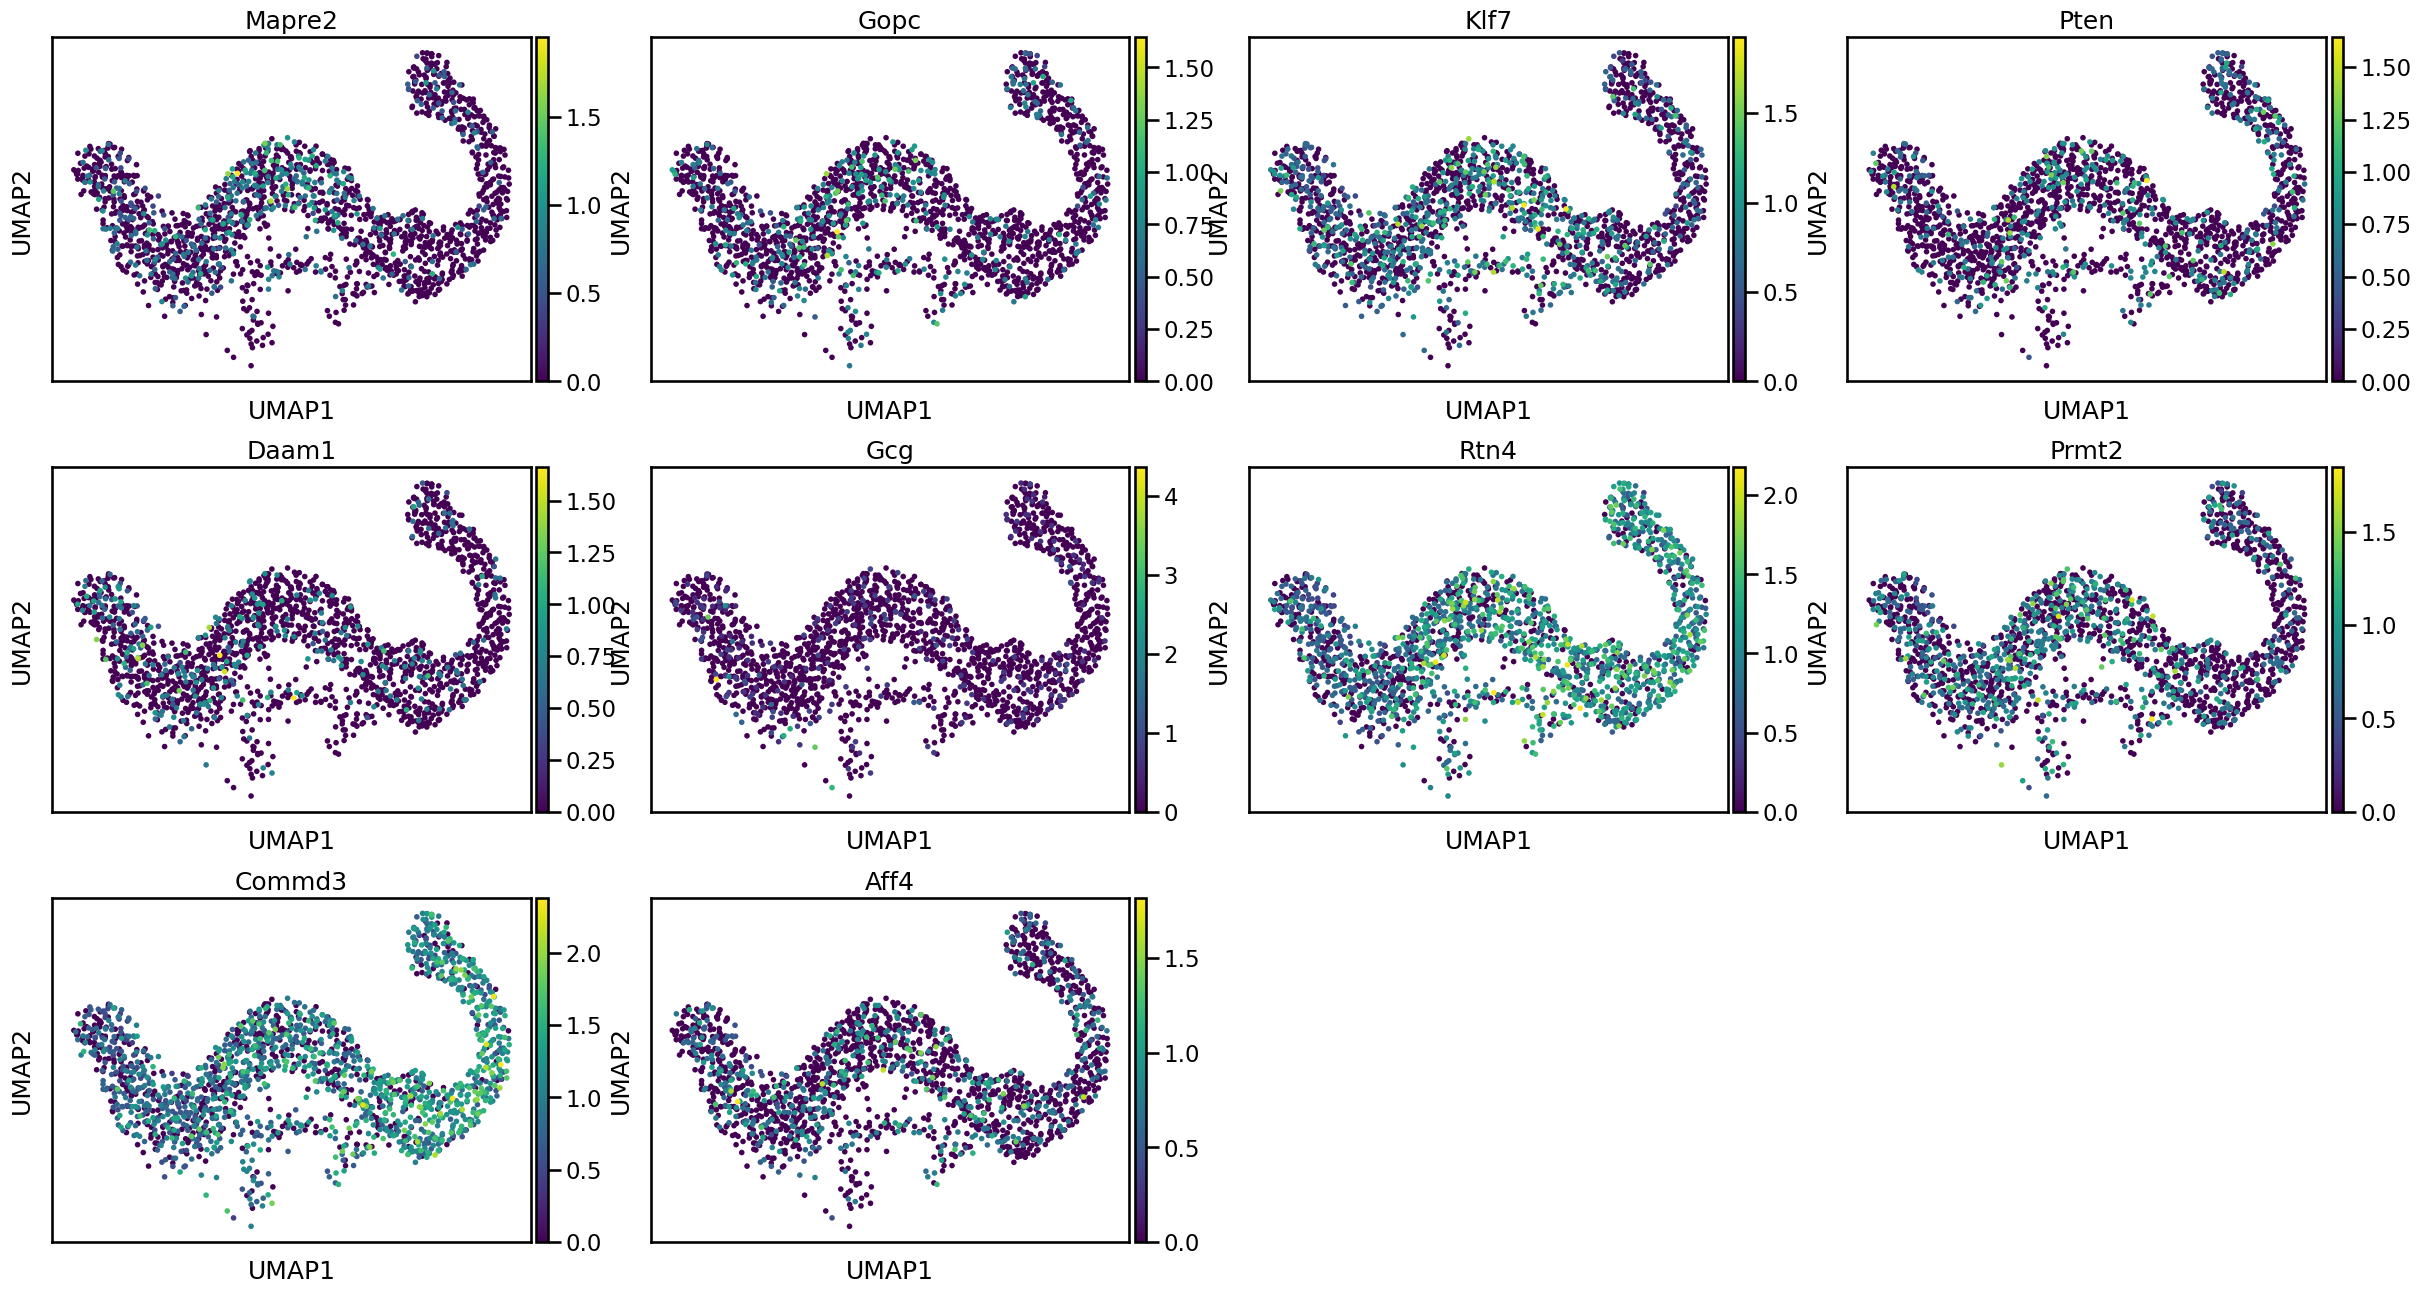

In [297]:
sc.pl.umap(adata, color=acc_matrix[0:10].index.tolist())

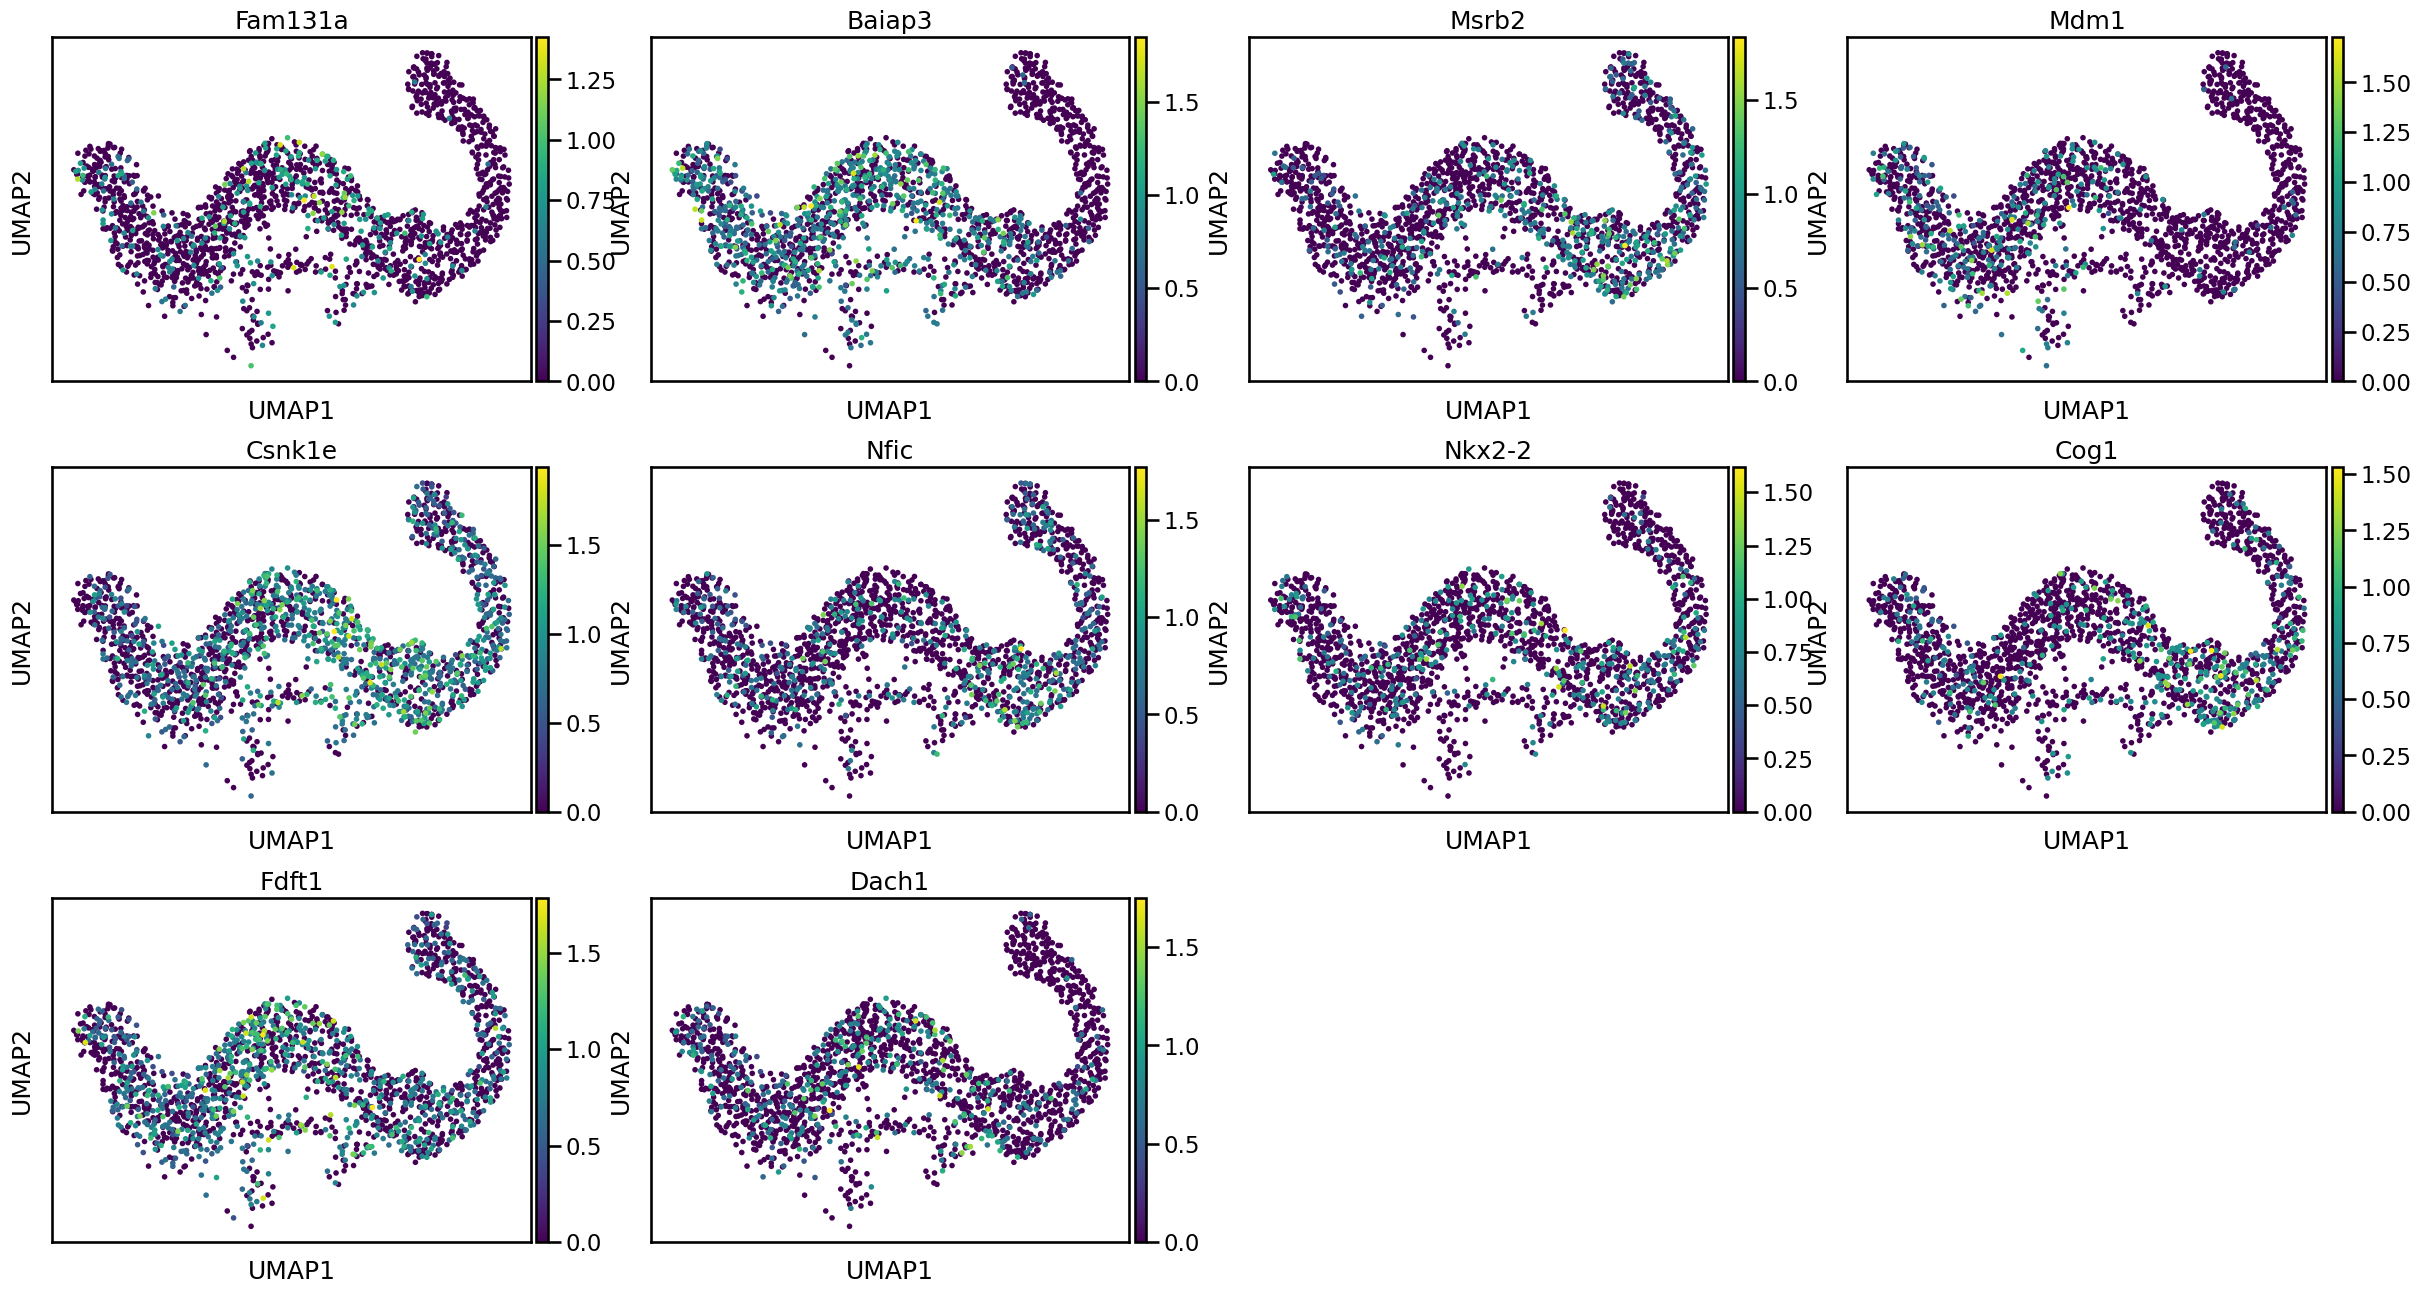

In [298]:
sc.pl.umap(adata, color=acc_matrix[-10:].index.tolist())

Plot accuracy by gene

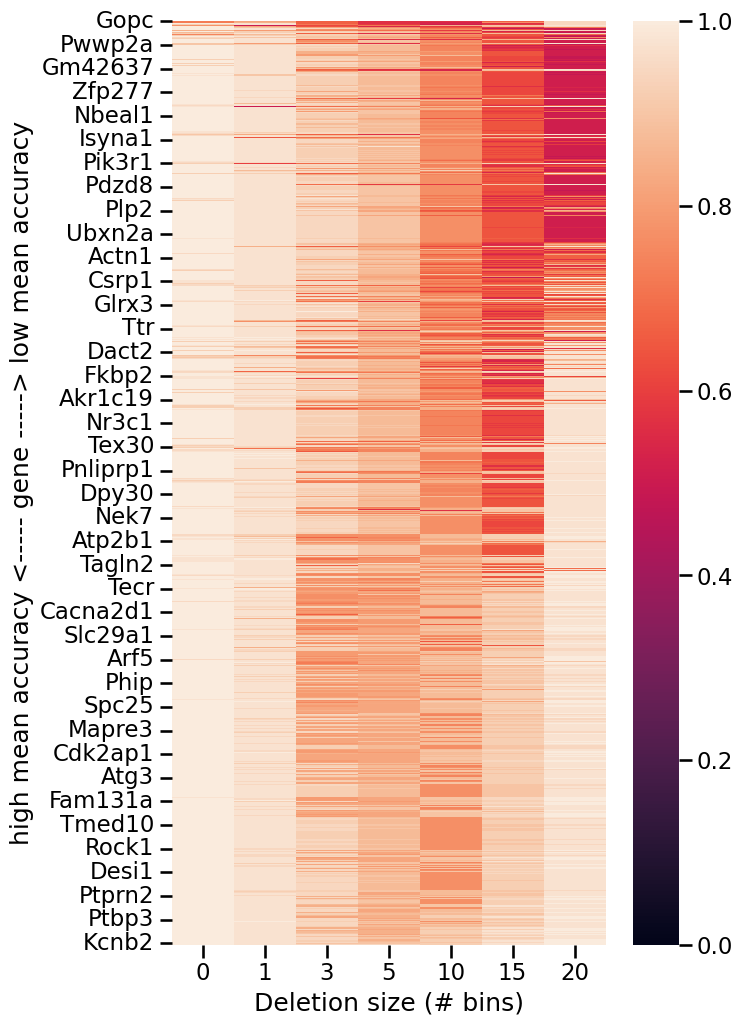

In [299]:
acc_matrix = match_outcome[['accuracy', 'gene', 'mm_size']].pivot(index='gene', columns='mm_size', values='accuracy')
acc_matrix = acc_matrix.dropna()

## order by mean accuracy
acc_matrix = acc_matrix.loc[acc_matrix.mean(1).sort_values().index]

with plt.rc_context({'figure.figsize':[7,12]}):
    sns.heatmap(acc_matrix, vmin=0, vmax=1);
    plt.xlabel("Deletion size (# bins)");
    plt.ylabel('high mean accuracy <----- gene -----> low mean accuracy')

### Make plot

In [3]:
match_outcome_del = pd.read_csv('./data/match_accuracy_pancreas.deletion.csv', index_col=0)
match_outcome_ins = pd.read_csv('./data/match_accuracy_pancreas.insertions.csv', index_col=0)

In [4]:
match_outcome_ins['frac_mm'] = (match_outcome_ins.mm_size / 40) * 100
match_outcome_del['frac_mm'] = (match_outcome_del.mm_size / 40) * 100

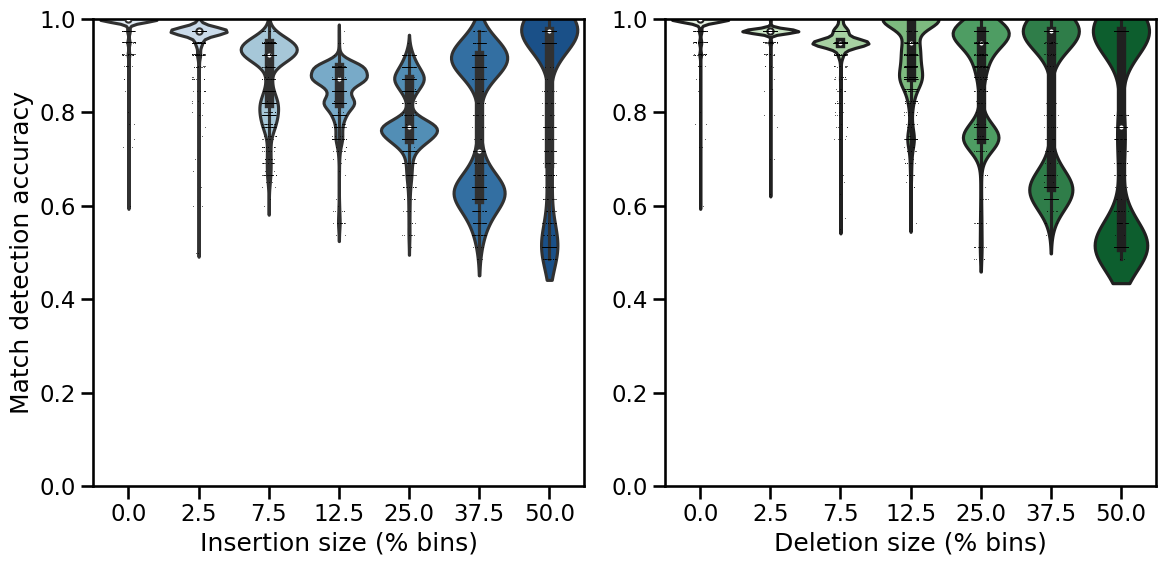

In [12]:
sns.set_context("talk")
with plt.rc_context({'figure.figsize':[12,6]}):
    plt.subplot(1,2,1)
    sns.violinplot(data=match_outcome_ins, x='frac_mm', y='accuracy', cut=True, scale='width', palette='Blues');
    sns.stripplot(data=match_outcome_ins, x='frac_mm', y='accuracy', color='black', s=0.5);
    plt.ylim(0,1.0);
    plt.xlabel("Insertion size (% bins)");
    plt.ylabel("Match detection accuracy");

    plt.subplot(1,2,2)
    sns.violinplot(data=match_outcome_del,  x='frac_mm', y='accuracy', cut=True, scale='width', palette='Greens');
    sns.stripplot(data=match_outcome_del, x='frac_mm', y='accuracy', color='black', s=0.5);
    plt.ylim(0,1.0);
    plt.xlabel("Deletion size (% bins)");
    plt.ylabel("");

    plt.tight_layout()
    plt.show()

### Simulating warps

Duplicate regions of pseudotshape in the query. 

In [ ]:
## to do

### Shift score
Taking area under the curve for the match matrix.
Look into `plot_comprehensive_alignment_landscape_plot`

`compute_alignment_area_diff_distance` (giving as A2 a perfect match case - diagonal of the matrix)

In [ ]:
## to do